# **Predicting Pulsar Stars**

In [0]:
# Import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from functools import *
from google.colab import files

np.set_printoptions(formatter = {'float': '{: 0.1f}'.format})

In [0]:
# Uploading files [pulsar_stars.csv]
# Source: https://www.kaggle.com/pavanraj159/predicting-a-pulsar-star
file_name = 'pulsar_stars.csv'
uploaded = files.upload()

Saving pulsar_stars.csv to pulsar_stars.csv


#### **Exploratory Data Analysis (EDA)**

In [0]:
# Loading the dataset
dataset = pd.read_csv(file_name, delimiter=',')

In [0]:
# Exploring the dataset
print("Number of Example (rows): %s" % dataset.shape[0])
print("Number of Features (columns): %s" % dataset.shape[1])

Number of Example (rows): 17898
Number of Features (columns): 9


In [0]:
# Inspecting the dataset
dataset.columns = ['mean_profile', 'standard_profile', 'kurtosis_profile', 'skewness_profile', 'mean_dmsnr', 'standard_dmsnr', 'kurtosis_dmsnr', 'skewness_dmsnr', 'target']
dataset.head()

,mean_profile,standard_profile,kurtosis_profile,skewness_profile,mean_dmsnr,standard_dmsnr,kurtosis_dmsnr,skewness_dmsnr,target
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [0]:
# View data types
dataset.info()

# Check if dataset free from null values
print('')
dataset.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
mean_profile        17898 non-null float64
standard_profile    17898 non-null float64
kurtosis_profile    17898 non-null float64
skewness_profile    17898 non-null float64
mean_dmsnr          17898 non-null float64
standard_dmsnr      17898 non-null float64
kurtosis_dmsnr      17898 non-null float64
skewness_dmsnr      17898 non-null float64
target              17898 non-null int64
dtypes: float64(8), int64(1)
memory usage: 1.2 MB



mean_profile        0
standard_profile    0
kurtosis_profile    0
skewness_profile    0
mean_dmsnr          0
standard_dmsnr      0
kurtosis_dmsnr      0
skewness_dmsnr      0
target              0
dtype: int64

#### **Visualize the distribution of each input features**

Range of the values (min, max, mean, median, etc.)

In [0]:
# Basic statistical details like percentile, mean, std etc. of a data frame
dataset.describe()

,mean_profile,standard_profile,kurtosis_profile,skewness_profile,mean_dmsnr,standard_dmsnr,kurtosis_dmsnr,skewness_dmsnr,target
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


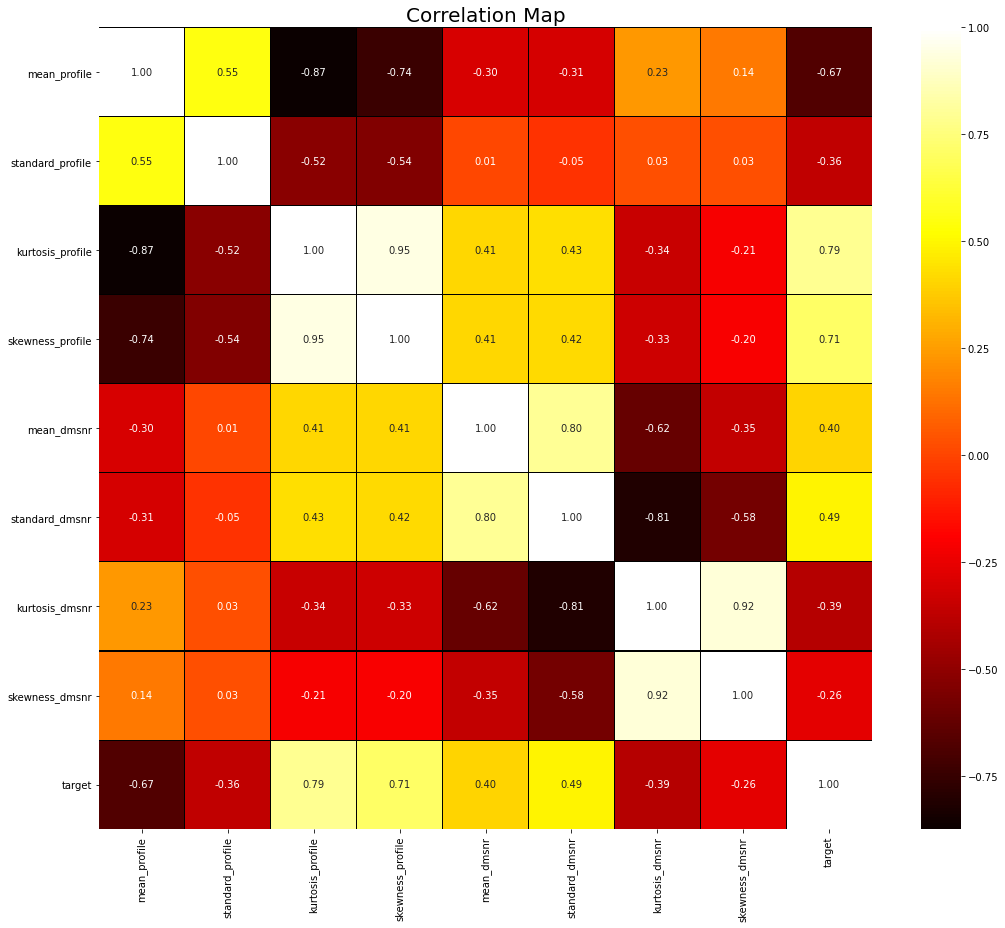

In [0]:
# Correlation between fields
plt.figure(figsize=(15, 13))
sns.heatmap(data=dataset.corr(), annot=True, cmap="hot", linewidths=0.1, fmt=".2f", linecolor="black")
plt.title("Correlation Map", fontsize=20)
plt.tight_layout()
plt.show()

Histograms distribution of each input features

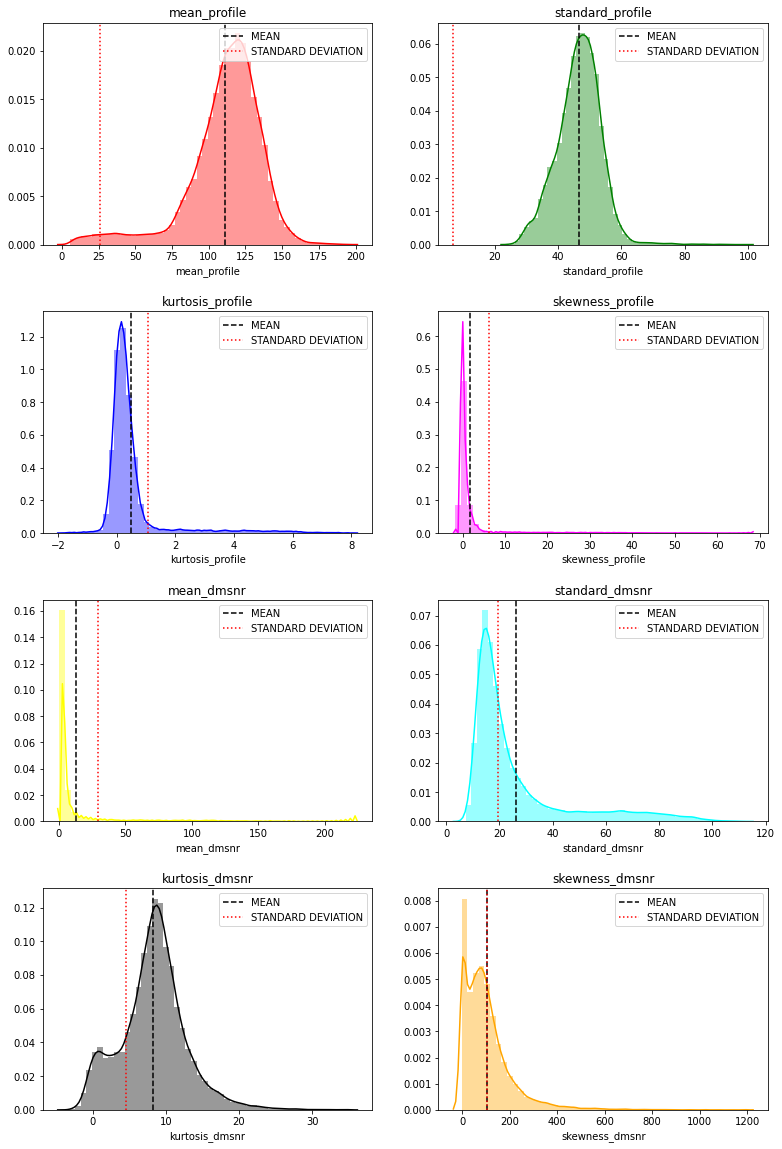

In [0]:
columns = ['mean_profile', 'standard_profile', 'kurtosis_profile', 'skewness_profile', 'mean_dmsnr', 'standard_dmsnr', 'kurtosis_dmsnr', 'skewness_dmsnr']
columns_length  = len(columns)
columns_colors  = ["red", "green", "blue", "magenta", "yellow", "cyan", "black", "orange"] 

# Make an iterator that aggregates elements from each of the iterables
import itertools
plt.figure(figsize=(13, 20))
for i, j, k in itertools.zip_longest(columns, range(columns_length), columns_colors):
    plt.subplot(columns_length/2, columns_length/4, j + 1)
    sns.distplot(dataset[i], color = k)
    plt.title(i)
    plt.subplots_adjust(hspace = 0.3)
    plt.axvline(dataset[i].mean(), color = "black", linestyle="dashed", label="MEAN")
    plt.axvline(dataset[i].std(), color = "red", linestyle="dotted", label="STANDARD DEVIATION")
    plt.legend(loc="upper right")

#### **Distribution of the output labels**
The data is imbalanced and will need to be resampled, such as oversampling, undersampling, or generate synthetic samples.

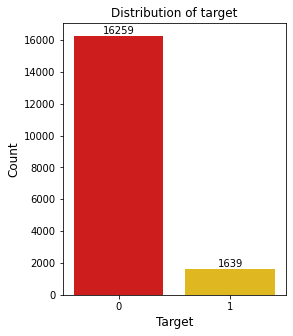

In [0]:
# Distribution of target class
plt.figure(figsize=(4, 5))
axs = sns.countplot(dataset['target'], palette='hot')
plt.title('Distribution of target', fontsize=12)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Count Annotation
for rec in axs.patches:
    axs.annotate(format(rec.get_height(), '.0f'), (rec.get_x() + rec.get_width() / 2.0, rec.get_height()), ha='center', va='center', xytext=(0, 5), textcoords = 'offset points', fontsize=10)

#### **Training and Validation Sets**

In [0]:
# Shuffle the dataset
# NOTE: shuffle dataframe in-place and reset the index
dataset = dataset.sample(frac=1).reset_index(drop=True)

# Convert Pandas Dataframe to Numpy dArray
dataset_np = dataset.values
X = dataset.drop('target', axis='columns').values
Y = dataset['target'].values

In [0]:
# Index for 20%
index_20percent = int(0.2 * len(dataset_np[:, 0]))  
print(index_20percent)

# Split into validation (20%) and training (80%)
XVALID = X[:index_20percent, :]
YVALID = Y[:index_20percent]

XTRAIN = X[index_20percent:, :]
YTRAIN = Y[index_20percent:]

3579


#### **Data Normalization**

**IMPORTANT**: Do standardization/normalization after spliting into train and test/validation. The reason is to avoid any data leakage. </br>
**Standardization/Normalization Techniques** </br>
* Standardization: typically means rescales data to have a mean of 0 and a standard deviation of 1 (unit variance). 
* Normalization: typically means rescales the values into a range of [0, 1]
* Normalization is a good technique to use when you do not know the distribution of your data or when you know the distribution is not Gaussian (a bell curve).
* Standardization assumes that your data has a Gaussian (bell curve) distribution. This does not strictly have to be true, but the technique is more effective if your attribute distribution is Gaussian.
* **Source Code**: https://github.com/badriadhikari/AI-2020spring/blob/master/notebooks/normalization_techniques.ipynb

In [0]:
## Mean normalization
min = XTRAIN.min(axis = 0) 
max = XTRAIN.max(axis = 0) 
mean = XTRAIN.mean(axis = 0)
XTRAIN = (XTRAIN - mean) / (max - min)
XVALID = (XVALID - mean) / (max - min)

## Rescaling
Ymax = YTRAIN.max()
YTRAIN = YTRAIN / Ymax
YVALID = YVALID / Ymax

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81c94f0048>,
      dtype=object)

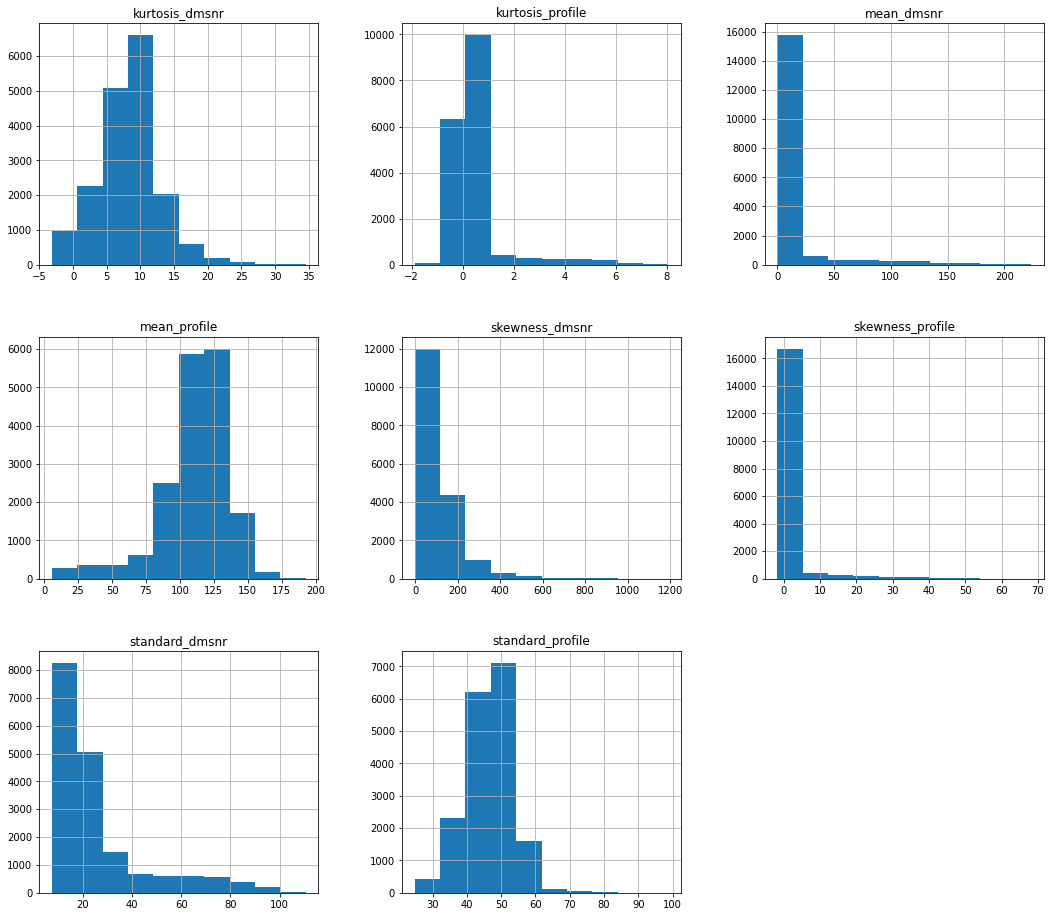

In [0]:
## Verifying
## Before Normalize
dataset.drop('target', axis='columns').hist(figsize=(18,16))

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81c73c8470>,
      dtype=object)

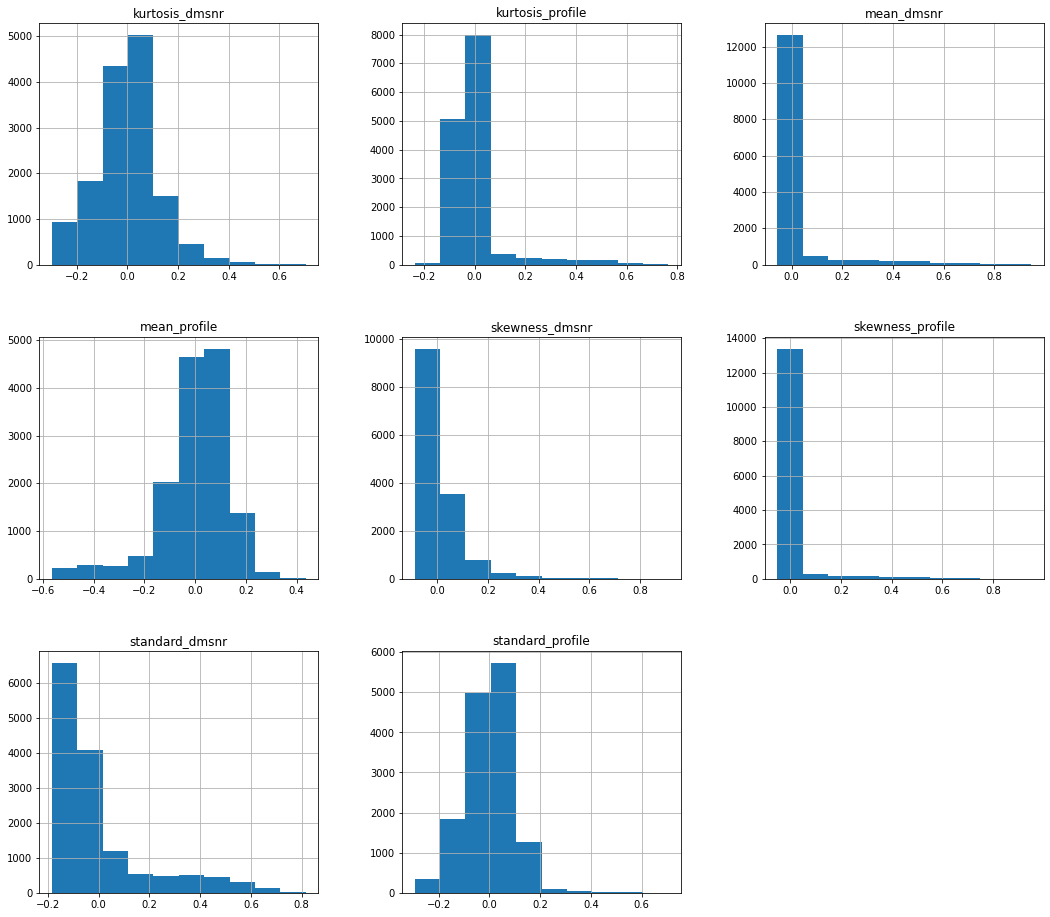

In [0]:
## Verifying
## After Normalize
dfx = pd.DataFrame(data=XTRAIN)
dfx.columns = ['mean_profile', 'standard_profile', 'kurtosis_profile', 'skewness_profile', 'mean_dmsnr', 'standard_dmsnr', 'kurtosis_dmsnr', 'skewness_dmsnr']
dfx.hist(figsize=(18,16))